### Preprocessing


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [65]:
%matplotlib inline
import tarfile
from google.colab import drive
import os
import pandas as pd
import csv
from shutil import copyfile, copy2, copy
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from numpy import argmax
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from keras_preprocessing.image import ImageDataGenerator
from textwrap import wrap
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC, CategoricalCrossentropy
from tensorflow_addons.metrics import F1Score
import json
import datetime
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import itertools

In [66]:
tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/freiburg_groceries_dataset.tar.gz", "r")
tar.extractall('/content')

In [67]:
dataset_path = '/content/images'
new_path = '/content/freiburg_groceries'
train_path = '/content/freiburg_groceries/train'
validation_path = '/content/freiburg_groceries/validation'
evaluation_path = '/content/freiburg_groceries/evaluation'

if not os.path.exists(new_path):
    os.makedirs(new_path)

if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.makedirs(os.path.join(train_path, 'images'))

if not os.path.exists(validation_path):
    os.makedirs(validation_path)
    os.makedirs(os.path.join(validation_path, 'images'))

if not os.path.exists(evaluation_path):
    os.makedirs(evaluation_path)
    os.makedirs(os.path.join(evaluation_path, 'images'))

In [68]:
dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(dataset_path)[:5]:
  for product_file in os.listdir(os.path.join(dataset_path, product)):
    dataset['file_name'].append(os.path.join(dataset_path, product, product_file))
    dataset['label'].append(product)

dataset_df = pd.DataFrame(dataset, columns=['file_name', 'label'])
#dataset_df

In [69]:
train_validate_filenames, evaluation_filenames, train_validate_labels, evaluation_labels = train_test_split(dataset_df['file_name'], dataset_df['label'], train_size=0.8, random_state=42, stratify=dataset_df['label'])

train_validate_df = pd.DataFrame(zip(train_validate_filenames, train_validate_labels), columns=['file_name', 'label'])
#print(train_test_df)

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(train_validate_df['file_name'], train_validate_df['label'], train_size=0.875, random_state=42, stratify=train_validate_df['label'])

train_df = pd.DataFrame(zip(train_filenames, train_labels), columns=['file_name', 'label'])
#print(train_df)

validation_df = pd.DataFrame(zip(validation_filenames, validation_labels), columns=['file_name', 'label'])
#print(validation_df)

evaluation_df = pd.DataFrame(zip(evaluation_filenames, evaluation_labels), columns=['file_name', 'label'])
#print(validation_df)

In [70]:
with open(os.path.join(train_path, 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(train_path, 'images', split[-1]))

In [71]:
with open(os.path.join(validation_path, 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(validation_path, 'images', split[-1]))

In [72]:
with open(os.path.join(evaluation_path, 'evaluation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(evaluation_filenames, evaluation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([split[-1], label])
        copyfile(file_name, os.path.join(evaluation_path, 'images', split[-1]))

<built-in method count of list object at 0x7ff3b40fe808>


In [111]:
class_indices = evaluation_generator.class_indices
class_indices_inverted = {v: k for k, v in class_indices.items()}

## Defining data augmentations

In [73]:
def training_data(file, path):
  global W_SUM
  global H_SUM
  img = cv2.imread(os.path.join(path, 'images', file),cv2.IMREAD_COLOR)
  shape = np.array(img).shape
  W_SUM += shape[0]
  H_SUM += shape[1]
  img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
  X.append(np.array(img))

def invert_image(img):
  return (255-img)

Found 707 validated image filenames belonging to 5 classes.
Found 102 validated image filenames belonging to 5 classes.
Found 203 validated image filenames belonging to 5 classes.


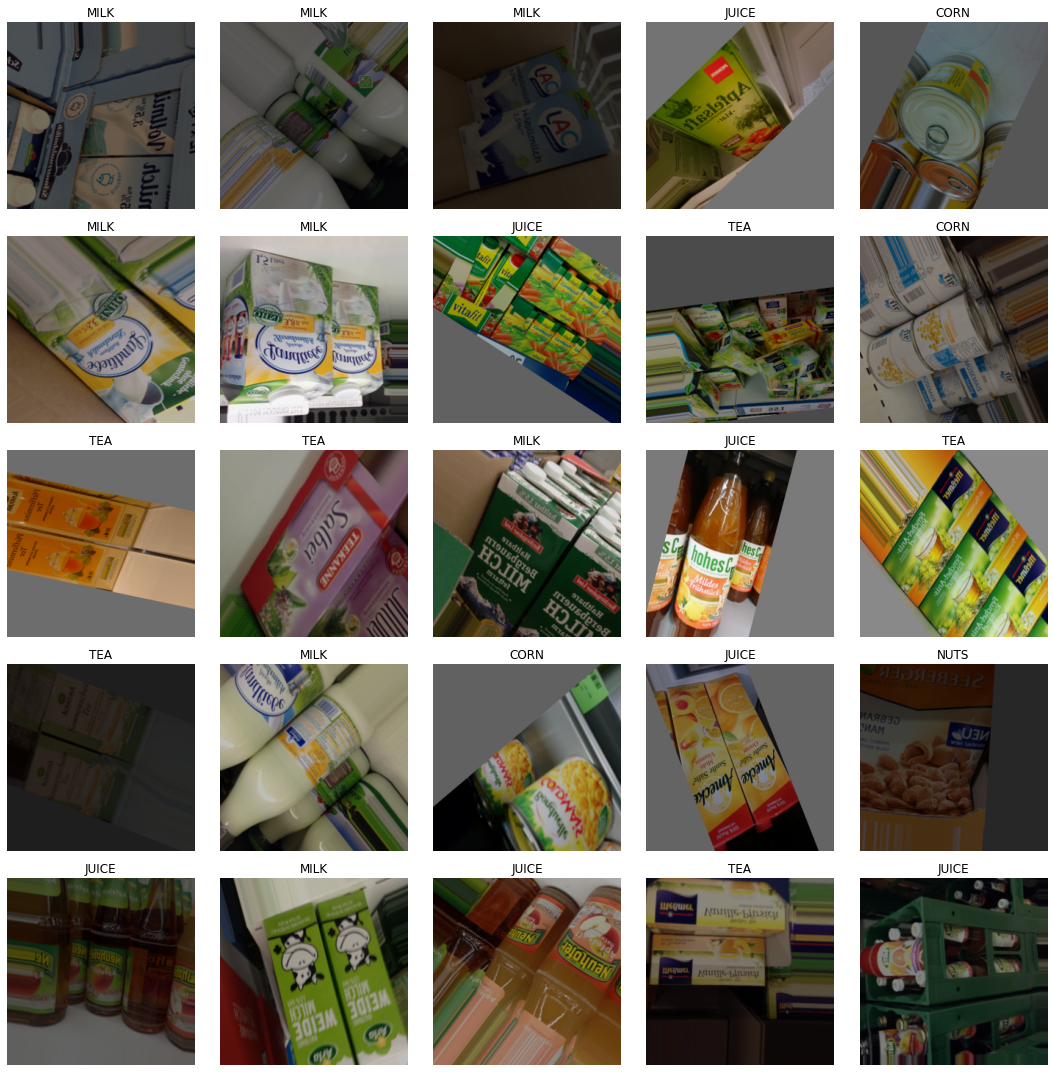

In [113]:
IMG_SIZE = 256
BATCH_SIZE = 128

train_df = pd.read_csv(os.path.join(train_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(validation_path, 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(evaluation_path, 'evaluation.csv'))

#X = []
#global W_SUM
#global H_SUM
#W_SUM = 0
#H_SUM = 0
#for file in train_df['file_name']:
#  training_data(file, path = train_path)

#for file in validation_df['file_name']:
#  training_data(file, path = validation_path)
  
#X = np.array(X)
#X=X/255

#print(W_SUM / X.shape[0])
#print(H_SUM / X.shape[0])
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=90,  
    zoom_range = 0.2,
    shear_range = 0.2,
    width_shift_range=0.2,  
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,  
    vertical_flip=True,
    rescale=1. / 255)

#train_datagen.fit(X)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

#validation_datagen.fit(X)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=os.path.join(train_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=os.path.join(validation_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=os.path.join(evaluation_path, 'images'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE, shuffle=False)

x,y = train_generator.next()

fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
num = 0
for i in range(5):
  for j in range (5):
    ax[i,j].imshow(x[num])
    inverted = class_indices_inverted[argmax(y[num])]
    ax[i,j].set_title("\n".join(wrap(inverted, 10)))
    ax[i,j].axis('off')
    num += 1
  num += 1
        
plt.tight_layout()

## Train Model

In [76]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet',
                                         )

In [77]:
base_model.trainable = False
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 127, 127, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 127, 127, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [78]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
dropout_layer = tf.keras.layers.Dropout(0.4)
prediction_layer = tf.keras.layers.Dense(5)
activation_layer = tf.keras.layers.Activation('softmax')

In [79]:
num_classes = len(train_generator.class_indices)
metrics = [CategoricalAccuracy(name='categorical_accuracy'),
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc'),
    CategoricalCrossentropy(label_smoothing=0.3),
    F1Score(name='f1score',num_classes=num_classes)]

In [80]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dropout_layer,
  prediction_layer,
  activation_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
_________________________________________________________________
activation_407 (Activation)  (None, 5)                 0         
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
_________________________________________________________________


In [105]:
num_epochs = 100

history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/100
6/6 [==============================] - 19s 3s/step - loss: 0.6857 - categorical_accuracy: 0.7383 - precision: 0.7969 - recall: 0.6549 - auc: 0.9405 - categorical_crossentropy: 1.4546 - f1score: 0.7337 - val_loss: 0.5358 - val_categorical_accuracy: 0.8039 - val_precision: 0.8706 - val_recall: 0.7255 - val_auc: 0.9662 - val_categorical_crossentropy: 1.3605 - val_f1score: 0.8091
Epoch 2/100
6/6 [==============================] - 16s 3s/step - loss: 0.6993 - categorical_accuracy: 0.7412 - precision: 0.7818 - recall: 0.6436 - auc: 0.9378 - categorical_crossentropy: 1.4518 - f1score: 0.7396 - val_loss: 0.5367 - val_categorical_accuracy: 0.8039 - val_precision: 0.8810 - val_recall: 0.7255 - val_auc: 0.9661 - val_categorical_crossentropy: 1.3587 - val_f1score: 0.8091
Epoch 3/100
6/6 [==============================] - 19s 3s/step - loss: 0.6825 - categorical_accuracy: 0.7426 - precision: 0.8125 - recall: 0.6803 - auc: 0.9408 - categorical_crossentropy: 1.4434 - f1score: 0.7437 - val

## Evaluation

In [107]:
model.evaluate(evaluation_generator)

2/2 [==============================] - 1s 548ms/step - loss: 0.5078 - categorical_accuracy: 0.7882 - precision: 0.8343 - recall: 0.7438 - auc: 0.9677 - categorical_crossentropy: 1.4622 - f1score: 0.7799


[0.5078414082527161,
 0.7881773114204407,
 0.8342541456222534,
 0.743842363357544,
 0.9676860570907593,
 1.4621961116790771,
 array([0.8095238, 0.8387097, 0.7118644, 0.7536232, 0.7857143],
       dtype=float32)]

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def get_image (path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = np.array(img).astype('float32')/255
    x = np.expand_dims(x, axis=0)
    return x

In [114]:
class_numbers_predicted = []
class_numbers_actual = []

labels_ = evaluation_df.groupby("label")
for label in labels_:
  for path in label[1]["file_name"]:
    x = get_image(os.path.join(evaluation_path, 'images', path))
    p = model.predict(x)
    predicted = class_indices_inverted[argmax(p)]
    class_numbers_predicted.append(argmax(p))
    actual = label[0]
    class_numbers_actual.append(class_indices[actual])

Confusion matrix, without normalization
[[15  0  1  3  0]
 [ 0 55  2  0  4]
 [ 0 10 19  1  2]
 [ 4  1  0 28  1]
 [ 0  7  4 13 33]]


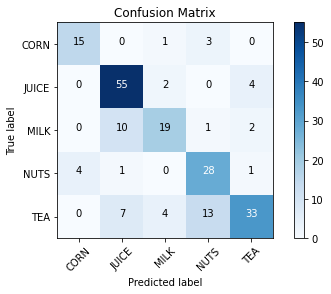

In [97]:
cm = confusion_matrix(y_true=class_numbers_actual, y_pred=class_numbers_predicted)
cm_plot_labels = evaluation_generator.class_indices
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[16  0  1  2  0]
 [ 0 54  3  0  4]
 [ 0  7 21  1  3]
 [ 6  1  0 25  2]
 [ 0  5  2  8 42]]


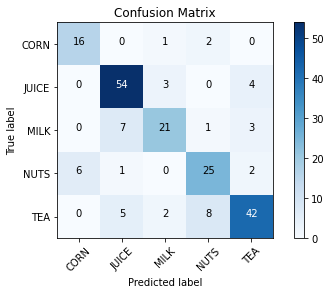

In [104]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Confusion matrix, without normalization
[[17  0  0  2  0]
 [ 0 52  3  0  6]
 [ 0  7 21  1  3]
 [ 6  0  0 26  2]
 [ 0  4  3  6 44]]


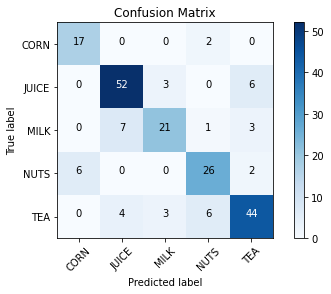

In [116]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Save and Load

In [ ]:
hist_df = pd.DataFrame(history.history) 

# save history to json:  
hist_json_file = '/content/drive/My Drive/Colab Notebooks/models/grozi120/history/InceptionResNetV2_imagenet_19_06_20_13_35_08_history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
model_path =  '/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_{}.h5'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
model.save(model_path) 
#model.load_weights('/content/drive/My Drive/Colab Notebooks/models/grozi5/InceptionResNetV2_imagenet_19_06_20_11_36_20.h5')